## Домашнее задание 1. Обучение LeNet

На прошлой лабораторной мы рассмотрели пример обучения небольшой нейронной сети для классификации датасета CIFAR-10. В качестве домашнего задания вам предлагается классификация предметов одежды из датасета [**Fashion MNIST**](https://pytorch.org/vision/main/generated/torchvision.datasets.FashionMNIST.html#torchvision.datasets.FashionMNIST). Вы можете начать с имплементации классической сверточной сети [LeNet](https://en.wikipedia.org/wiki/LeNet) и улучшить ее методами, которые мы обсудили на лекции (dropout, batchnorm, etc).

In [12]:

import os
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"


In [8]:
import torchvision
from torch.utils.data import DataLoader, Dataset, TensorDataset
from sklearn.model_selection import train_test_split
from torchvision import transforms
from copy import deepcopy
import numpy as np
import torch
from tqdm.notebook import tqdm


import torch.nn as nn
import torch.optim as optim

import matplotlib.pyplot as plt




# Загрузка датасета
fashion_mnist_dataset = torchvision.datasets.FashionMNIST(root="fashion",  download=True,transform=transforms.ToTensor())
# Содержит 60000 семплов и 10 классов
images = fashion_mnist_dataset.data.view([60000, 1, 28, 28]).float()

labels = deepcopy(fashion_mnist_dataset.targets)


# labels = fashion_mnist_dataset.targets.clone().long()
# labels = torch.clamp(labels, 0, 9)  

print("Min label:", labels.min().item())
print("Max label:", labels.max().item())
print("Label тип:", labels.dtype)



X_train, X_val, y_train, y_val = train_test_split(images, labels, test_size=0.01)

train_data = TensorDataset(X_train, y_train)
val_data = TensorDataset(X_val, y_val)
batch_size = 128

train_dl = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_dl = DataLoader(val_data, batch_size=len(val_data))

Min label: 0
Max label: 9
Label тип: torch.int64


In [14]:
x, y = next(iter(train_dl))
print(x.shape)  


torch.Size([128, 1, 28, 28])


## Архитектура LeNet

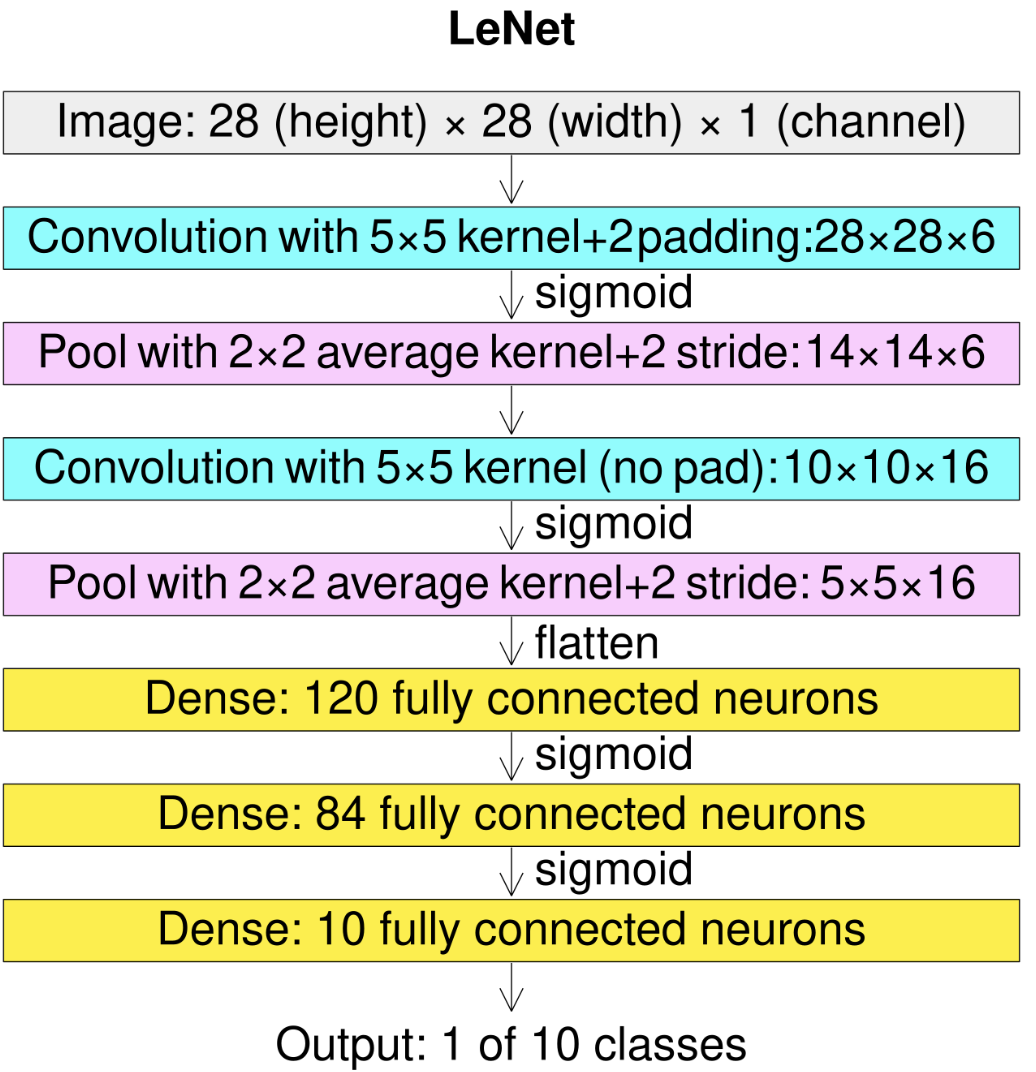



### **Задание 1**: закончите имплементацию LeNet согласно диаграме сверху

In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        self.c1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5, padding=2)  # 28x28 - 28x28
        self.s2 = nn.AvgPool2d(kernel_size=2, stride=2)                                # 28x28 - 14x14
        self.c3 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5)             # 14x14 - 10x10
        self.s4 = nn.AvgPool2d(kernel_size=2, stride=2)                                # 10x10 - 5x5
        self.c5 = nn.Conv2d(in_channels=16, out_channels=120, kernel_size=5)           # 5x5 - 1x1
        self.f6 = nn.Linear(120, 84)
        self.output = nn.Linear(84, 10)
        self.sigmoid = nn.Sigmoid()


    def forward(self, x):
        x = self.sigmoid(self.c1(x))
        x = self.s2(x)
        x = self.sigmoid(self.c3(x))
        x = self.s4(x)
        x = self.sigmoid(self.c5(x))  # [-1, 120, 1, 1]
        assert x.shape[2:] == (1, 1), f"Что то пошло не так:  {x.shape[2:]}"

        x = x.view(x.size(0), -1)     # Flatten: [-1, 120]
        x = self.sigmoid(self.f6(x))  # [-1, 84]
        x = self.output(x)            # [-1, 10]
        return x


### **Задание 2**: Напишите функцию обучения

Вы можете воспользоваться кодом из прошлой лабораторной работы

Посчитайте точность на валидационном сете. 

In [6]:
def train_model(model, train_dl, val_dl, epochs=10, lr=0.01, device='cuda' if torch.cuda.is_available() else 'cpu'):
    model = model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=lr)

    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        loop = tqdm(train_dl, dynamic_ncols=True)
        loop.set_description(f"Epoch {epoch+1}/{epochs}")

        for inputs, labels in loop:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

            loop.set_postfix(loss=loss.item(), acc=100. * correct / total)

        epoch_loss = running_loss / len(train_dl.dataset)
        epoch_acc = correct / total
        train_losses.append(epoch_loss)
        train_accuracies.append(epoch_acc)

        # Валидация
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0

        with torch.no_grad():
            for inputs, labels in val_dl:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item() * inputs.size(0)
                _, preds = torch.max(outputs, 1)
                val_correct += (preds == labels).sum().item()
                val_total += labels.size(0)

        val_loss /= len(val_dl.dataset)
        val_acc = val_correct / val_total
        val_losses.append(val_loss)
        val_accuracies.append(val_acc)

        loop.set_postfix({
            'Train Loss': f'{epoch_loss:.4f}',
            'Train Acc': f'{epoch_acc*100:.2f}%',
            'Val Loss': f'{val_loss:.4f}',
            'Val Acc': f'{val_acc*100:.2f}%'
        })

    print("\nОбучение завершено.")
    print(f"Финальный Train Loss: {train_losses[-1]:.4f}, Accuracy: {train_accuracies[-1]:.4f}")
    print(f"Финальный Val Loss: {val_losses[-1]:.4f}, Accuracy: {val_accuracies[-1]:.4f}")

    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Val Loss')
    plt.title("Loss по эпохам")
    plt.xlabel("Эпоха")
    plt.ylabel("Loss")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(train_accuracies, label='Train Acc')
    plt.plot(val_accuracies, label='Val Acc')
    plt.title("Accuracy по эпохам")
    plt.xlabel("Эпоха")
    plt.ylabel("Accuracy")
    plt.legend()

    plt.tight_layout()
    plt.show()


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]


Обучение завершено.
Финальный Train Loss: 2.3016, Accuracy: 0.1122
Финальный Val Loss: 2.3012, Accuracy: 0.1135


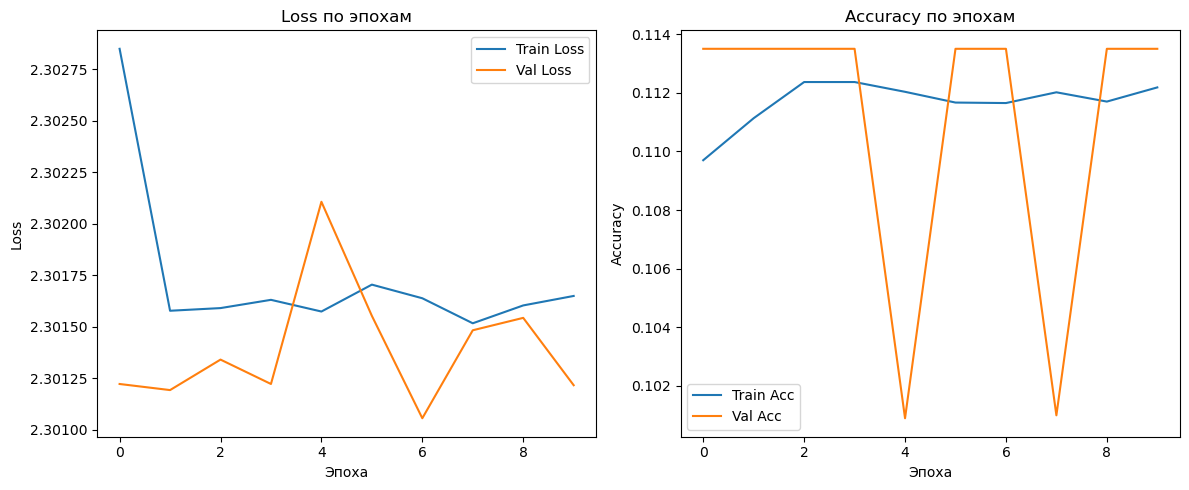

In [7]:
model = LeNet()
train_model(model, train_dl, val_dl, epochs=10, lr=0.01)


### **Задание 3**: Улучшите обучение продвинутыми методами

Вы можете добавить
- Dropout;
- BatchNorm;
- Data augmentation;
- Больше сверток к сети;
- Функции активации (ReLU, tahn, etc);
- Adam optimizer вместе с LR scheduler

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

#  Аугментации 
train_transform = transforms.Compose([
    transforms.RandomRotation(10),
    transforms.RandomAffine(0, translate=(0.1, 0.1)),
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

val_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

train_dataset = datasets.MNIST(root='./data', train=True, transform=train_transform, download=True)
val_dataset = datasets.MNIST(root='./data', train=False, transform=val_transform, download=True)

train_dl = DataLoader(train_dataset, batch_size=128, shuffle=True)
val_dl = DataLoader(val_dataset, batch_size=128, shuffle=False)




In [2]:

class FashionLeNet(nn.Module):
    def __init__(self):
        super(FashionLeNet, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1),     # 28x28 - 28x28
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),                              # 28x28 - 14x14
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, padding=1),    # 14x14 - 14x14
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),                              # 14x14 - 7x7
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3),              # 7x7 - 5x5
            nn.BatchNorm2d(128),
            nn.ReLU()
        )
        self.dropout = nn.Dropout(0.5)
        self.fc1 = nn.Linear(128 * 5 * 5, 256)
        self.fc2 = nn.Linear(256, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = x.view(x.size(0), -1)  
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.dropout(F.relu(self.fc2(x)))
        x = self.fc3(x)
        return x

In [ ]:
# Обучение 
def train_model(model, train_dl, val_dl, epochs=10, lr=0.001, device='cuda' if torch.cuda.is_available() else 'cpu'):
    model = model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)

    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        loop = tqdm(train_dl, dynamic_ncols=True)
        loop.set_description(f"Epoch {epoch+1}/{epochs}")

        for inputs, labels in loop:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

            loop.set_postfix(loss=loss.item(), acc=100. * correct / total)

        epoch_loss = running_loss / len(train_dl.dataset)
        epoch_acc = correct / total
        train_losses.append(epoch_loss)
        train_accuracies.append(epoch_acc)

        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0

        with torch.no_grad():
            for inputs, labels in val_dl:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item() * inputs.size(0)
                _, preds = torch.max(outputs, 1)
                val_correct += (preds == labels).sum().item()
                val_total += labels.size(0)

        val_loss /= len(val_dl.dataset)
        val_acc = val_correct / val_total
        val_losses.append(val_loss)
        val_accuracies.append(val_acc)

        scheduler.step()

        # print(f"Epoch [{epoch+1}/{epochs}] - "
        #       f"Train Loss: {epoch_loss:.4f}, Acc: {epoch_acc:.4f} | "
        #       f"Val Loss: {val_loss:.4f}, Acc: {val_acc:.4f}")

    print("\n Обучение завершено.")
    print(f"Train Loss: {train_losses[-1]:.4f}, Acc: {train_accuracies[-1]:.4f}")
    print(f"Val Loss:   {val_losses[-1]:.4f}, Acc: {val_accuracies[-1]:.4f}")

    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Val Loss')
    plt.title("Loss по эпохам")
    plt.xlabel("Эпоха")
    plt.ylabel("Loss")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(train_accuracies, label='Train Acc')
    plt.plot(val_accuracies, label='Val Acc')
    plt.title("Accuracy по эпохам")
    plt.xlabel("Эпоха")
    plt.ylabel("Accuracy")
    plt.legend()

    plt.tight_layout()
    plt.show()


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]


 Обучение завершено.
Train Loss: 0.0705, Acc: 0.9812
Val Loss:   0.0229, Acc: 0.9921


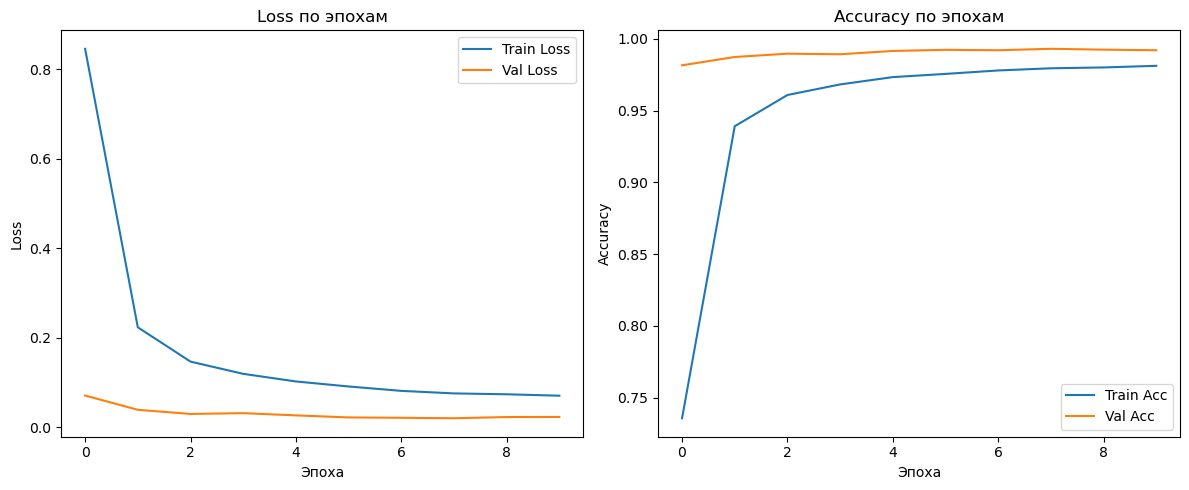

In [ ]:
model = FashionLeNet()
train_model(model, train_dl, val_dl, epochs=10, lr=0.0001)